In [1]:
import sys
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit/data_preprocessing_code')
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit')
import support_functions as sf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp
import bandit_preprocessing as bp
import sklearn.linear_model
from sklearn import discriminant_analysis
from sklearn import cross_validation
from sklearn import model_selection
from sklearn import tree as Tree
from sklearn import ensemble
from sklearn import preprocessing
from IPython.display import Image
from sklearn.externals.six import StringIO
import pydotplus
import sklearn.tree
%matplotlib inline 

//anaconda/envs/CaGRIN/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load in trial data and convert into switches

### (Drop current trial duration)

In [79]:
data = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/processed_data/master_8020_df.csv',index_col=0)
data = data.drop('0_trialDuration',axis=1)

switches = np.abs(np.diff(data['Decision'].values))
data = data.iloc[1:,:]
data['Switch'] = switches
feature_names = data.columns.values[:-1]
data.head(4)

,Previous_10_Left_Choice,Previous_10_Right_Choice,Previous_10_Left_Reward,Previous_10_Right_Reward,Streak,5_Port,5_Reward,5_ITI,5_trialDuration,4_Port,...,2_Reward,2_ITI,2_trialDuration,1_Port,1_Reward,1_ITI,1_trialDuration,0_ITI,Decision,Switch
1,10.0,0.0,7.0,0.0,-2.0,1.0,1.0,2.405,0.463,1.0,...,0.0,2.133,0.482,1.0,0.0,1.411,0.435,2.169,0.0,1.0
2,9.0,1.0,6.0,0.0,-3.0,1.0,1.0,2.379,0.367,1.0,...,0.0,1.411,0.435,0.0,0.0,2.169,0.395,3.838,0.0,0.0
3,8.0,2.0,5.0,0.0,-4.0,1.0,1.0,2.234,0.325,1.0,...,0.0,2.169,0.395,0.0,0.0,3.838,0.469,1.846,1.0,1.0
4,8.0,2.0,5.0,0.0,1.0,1.0,0.0,2.133,0.482,1.0,...,0.0,3.838,0.469,1.0,1.0,1.846,0.378,1.527,1.0,0.0


In [3]:
np.sum(data.duplicated())

0

In [80]:
#extract features and decisions
x = data.iloc[:,:-2].values
y = data.iloc[:,-1].values

#split into training and testing
n_trials = x.shape[0]
shuf_inds = np.random.permutation(n_trials)
split_ind = int(n_trials*0.9)

x_train = x[shuf_inds[:split_ind],:]
y_train = y[shuf_inds[:split_ind]]

x_test = x[shuf_inds[split_ind:],:]
y_test = y[shuf_inds[split_ind:]]

In [81]:
print('# train trials: %.0f | # switches: %.0f --> %.01f percent' % (y_train.shape[0],np.sum(y_train),np.sum(y_train)*100.0/y_train.shape[0]))
print('# test trials: %.0f | # switches: %.0f --> %.01f percent' % (y_test.shape[0],np.sum(y_test),np.sum(y_test)*100.0/y_test.shape[0]))

# train trials: 10192 | # switches: 806 --> 7.9 percent
# test trials: 1133 | # switches: 91 --> 8.0 percent


In [6]:
num_stays = np.sum(y == 0)
num_switches = np.sum(y)
print(num_stays)
print(num_switches)

10428
897.0


In [7]:
np.sum(x_train[:,22] == 0)

3015

In [8]:
np.sum(y_train[x_train[:,22] == 0])

714.0

(-1.0072485716611363,
 1.000000011663605,
 -1.001340205954091,
 1.0072683556410944)

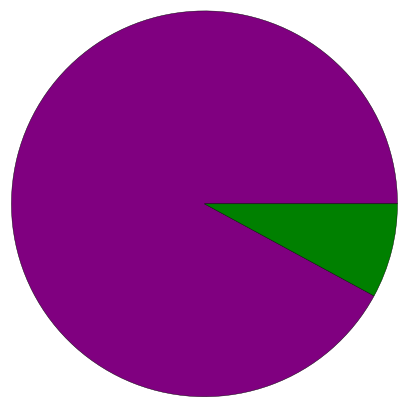

In [9]:
plt.figure(figsize=(5,5))
plt.pie([num_stays,num_switches],colors=['purple','green'])
plt.axis('equal')

# Benchmark Models

## 1. Predict switch whenever previous reward == 0

In [10]:
y_predict_bench = (x_test[:,22] == 0).astype('int')
acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict_bench,y_test,confusion=False)

          Predicted NO  Predicted YES
True NO          779.0          266.0
True YES          13.0           75.0

F1: 0.350

Accuracy on class 0: 0.75
Accuracy on class 1: 0.85



## 2. Randomly guess stay or switch

In [11]:
y_predict_rand = (np.random.uniform(size=y.shape[0]) >= 0.5).astype('int')
y_predict_loseswitch = (x[:,22] == 0).astype('int')

In [12]:
np.sum(y_predict_rand)

5591

In [13]:
y.shape[0]

11325

In [14]:
acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict_rand,y,confusion=False)

          Predicted NO  Predicted YES
True NO         5274.0         5154.0
True YES         460.0          437.0

F1: 0.135

Accuracy on class 0: 0.51
Accuracy on class 1: 0.49



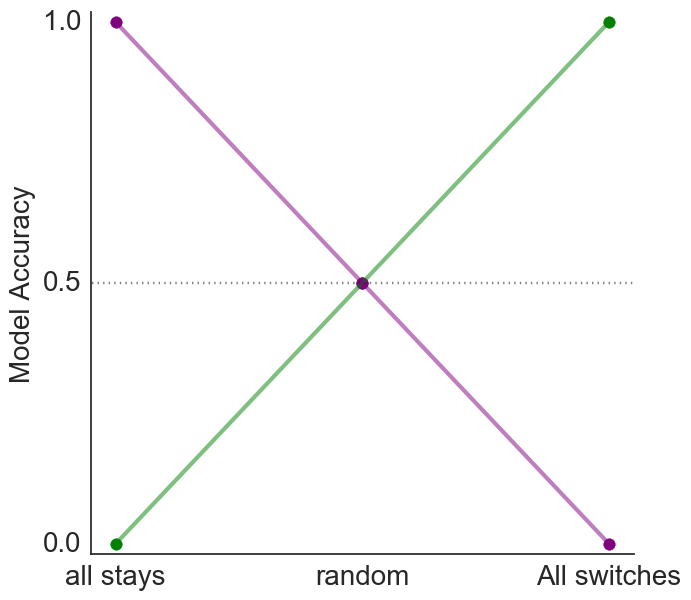

In [15]:
sns.set_style('white')
plt.figure(figsize=(7,7))
plt.plot([0,1,2],[0,0.5,1],color='green',alpha=0.5,linewidth=3)
plt.plot([0,1,2],[1,0.5,0],color='purple',alpha=0.5,linewidth=3)
plt.scatter(x=[0,1,2],y=[0,0.5,1],label='switching accuracy',color='green',s=70)
plt.scatter(x=[0,1,2],y=[1,0.5,0],label='staying accuracy',color='purple',s=70)
plt.hlines(y=0.5,xmin=-0.5,xmax=2.5,linestyles='dotted',alpha=0.5)
plt.xlim(-0.1,2.1)
plt.yticks([0,0.5,1],fontsize=20)
plt.ylabel('Model Accuracy',fontsize=20)
plt.xticks([0,1,2],['all stays','random','All switches'],fontsize=20)
plt.ylim(-0.02,1.02)

sns.despine()

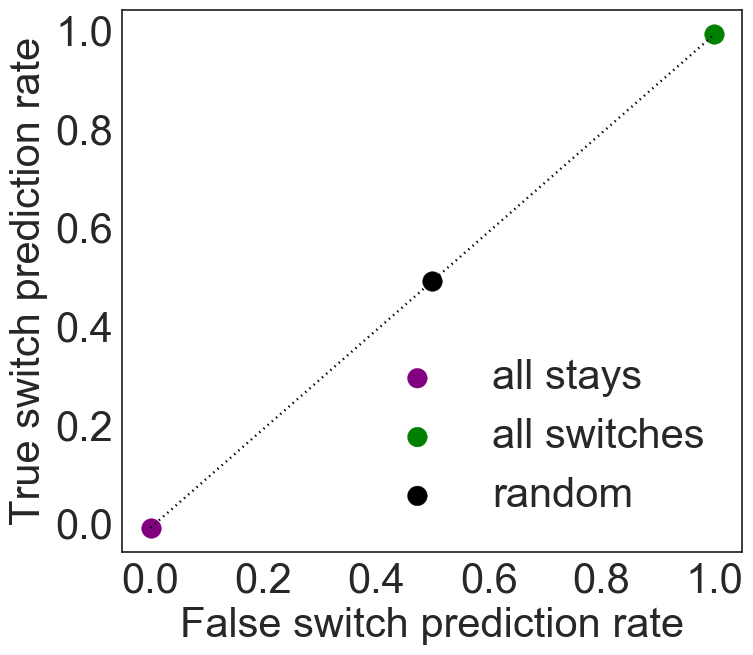

In [16]:
plt.figure(figsize=(8,7))
plt.scatter(0,0,color='purple',label='all stays',s=200)
plt.scatter(1,1,color='green',label='all switches',s=200)
plt.scatter(0.5,0.5,color='black',label='random',s=200)
plt.plot(np.linspace(0,1),np.linspace(0,1),color='black',linestyle='dotted')
plt.legend(loc='lower right',fontsize=30)
plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('True switch prediction rate',fontsize=30)
plt.xlabel('False switch prediction rate',fontsize=30)

# Logistic Regression

In [17]:
'''
Logistic Regression
'''
P = np.arange(0,1,0.01)

acc_cv = []

for i,p in enumerate(P):
    prior = np.array([1.0-p,p])
    logreg = sklearn.linear_model.LogisticRegressionCV(class_weight = {0:1.0-p,1:p})
    
    kf = cross_validation.KFold(x_train.shape[0],n_folds=3)
    cum_acc_pos = 0
    cum_acc_neg = 0
    
    for train_index,test_index in kf:
        x_train_cv = x_train[train_index,:]
        y_train_cv = y_train[train_index]
        x_test_cv = x_train[test_index,:]
        y_test_cv = y_train[test_index]

        logreg.fit(x_train_cv,y_train_cv)
        y_predict = logreg.predict(x_test_cv)
        
        acc_pos,acc_neg,F1 = sf.score_both_and_confuse(y_predict,y_test_cv,confusion=False,disp=False)
        
        cum_acc_pos += acc_pos
        cum_acc_neg += acc_neg

    acc_cv.append([cum_acc_pos / 3.0,cum_acc_neg / 3.0])

acc_cv = np.asarray(acc_cv)

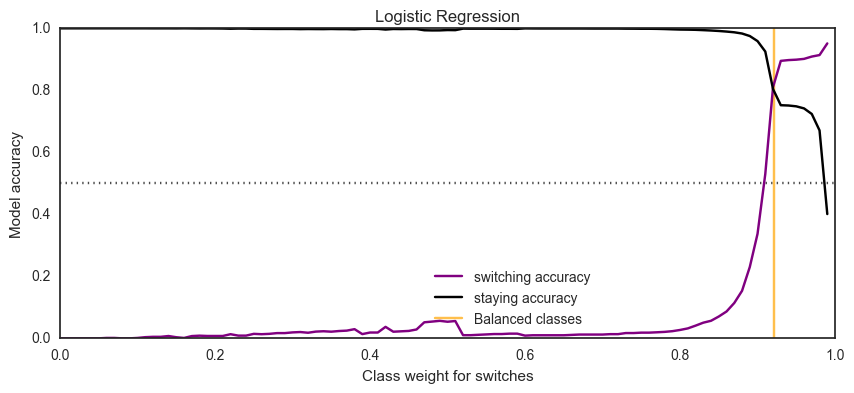

In [18]:
balanced_weight = 1.0 - np.sum(y_train).astype('float') / y_train.shape[0]

plt.figure(figsize=(10,4))
plt.plot(P,acc_cv[:,0],color='purple',label='switching accuracy')
plt.plot(P,acc_cv[:,1],color='black',label='staying accuracy')
plt.hlines(y=0.5,xmin=0,xmax=1,color='black',alpha=0.7,linestyle='dotted')
plt.vlines(x=balanced_weight,ymin=0,ymax=1,alpha=0.7,color='orange',label='Balanced classes')
plt.legend(loc='lower right',bbox_to_anchor=[0.7,0])
plt.xlim(0,1)
plt.xlabel('Class weight for switches')
plt.ylabel('Model accuracy')
plt.title('Logistic Regression')

In [82]:
logreg = sklearn.linear_model.LogisticRegressionCV(Cs=50,penalty='l2',class_weight='balanced')
logreg.fit(x_train,y_train)
y_predict_logreg = logreg.predict(x_test)
acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict_logreg,y_test,confusion=False)

          Predicted NO  Predicted YES
True NO          820.0          222.0
True YES          12.0           79.0

F1: 0.403

Accuracy on class 0: 0.79
Accuracy on class 1: 0.87



In [83]:
logreg.C_

array([ 0.0001])

In [21]:
504/641

0.7862714508580343

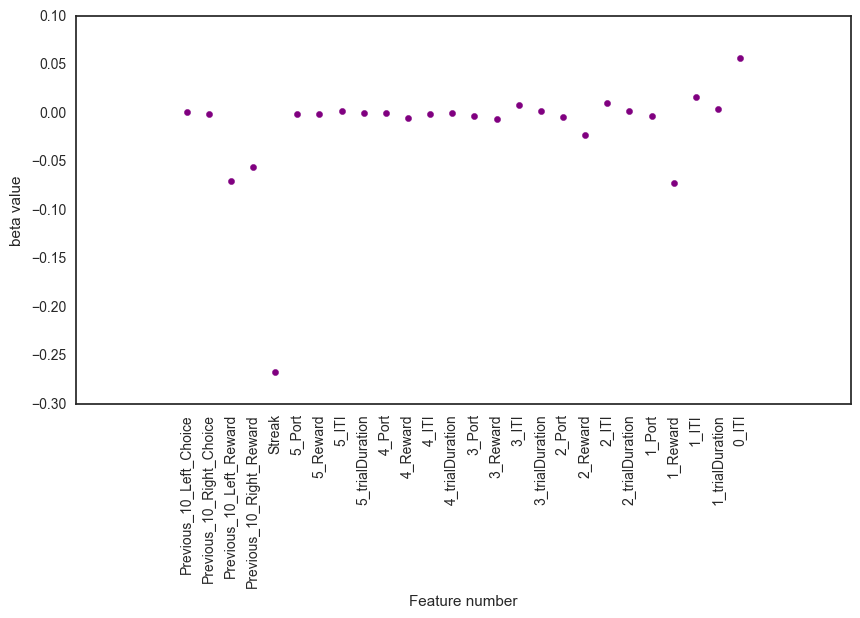

In [22]:
coefs = logreg.coef_
plt.figure(figsize=(10,5))
plt.scatter(np.arange(coefs[0].shape[0]),coefs[0],color='purple')
plt.xticks(np.arange(coefs[0].shape[0]),feature_names,rotation='vertical')
plt.ylabel('beta value')
plt.xlabel('Feature number')

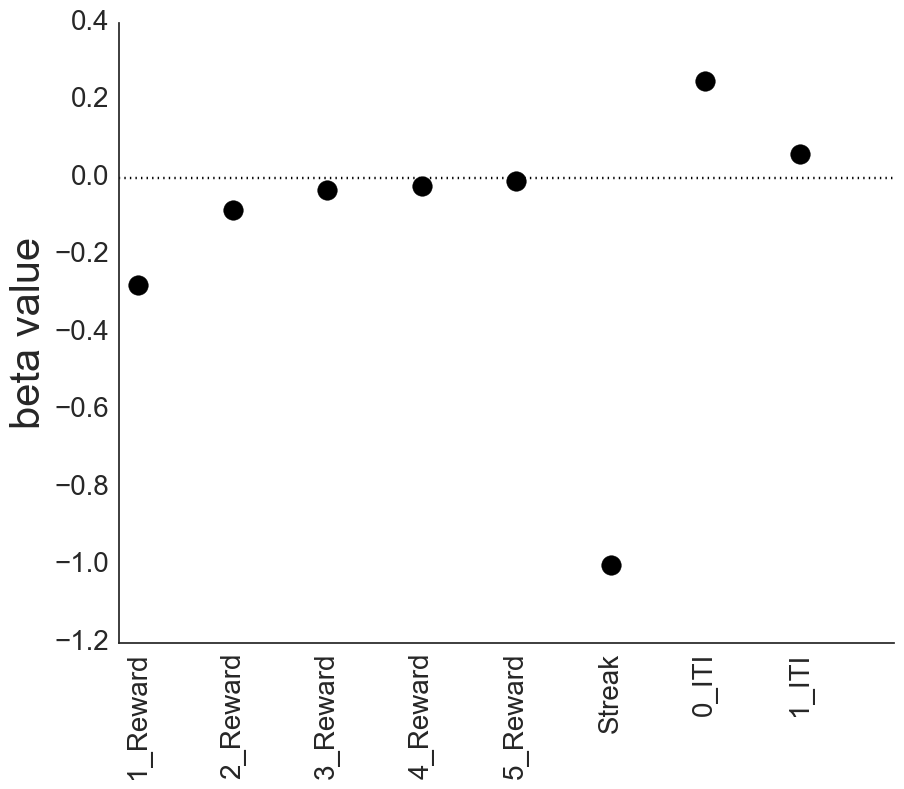

In [128]:
feature_order = ['1_Reward','2_Reward','3_Reward','4_Reward','5_Reward','Streak','0_ITI','1_ITI']
order = []

for f in feature_order:
    order.append(data.columns.get_loc(f))

coefs_lr = logreg.coef_[0]
coefs_lr = coefs_lr / np.abs(coefs_lr).max()
plt.figure(figsize=(10,8))
plt.scatter(np.arange(len(order)),coefs_lr[order],color='black',s=200)
plt.xticks(np.arange(len(order)),feature_names[order],rotation='vertical',fontsize=20)
plt.yticks(fontsize=20)
plt.hlines(y=0,xmin=-0.5,xmax=27,linestyle='dotted')
plt.xlim(-0.2,8)
plt.ylabel('beta value',fontsize=30)
sns.despine()

In [76]:
logreg.

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

# LDA

In [23]:
'''
LDA
'''
P = np.arange(0,1,0.01)

acc_cv = []

for i,p in enumerate(P):
    prior = np.array([1.0-p,p])
    lda = discriminant_analysis.LinearDiscriminantAnalysis(priors = prior)
    
    kf = cross_validation.KFold(x_train.shape[0],n_folds=3)
    cum_acc_pos = 0
    cum_acc_neg = 0
    
    for train_index,test_index in kf:
        x_train_cv = x_train[train_index,:]
        y_train_cv = y_train[train_index]
        x_test_cv = x_train[test_index,:]
        y_test_cv = y_train[test_index]

        lda.fit(x_train_cv,y_train_cv)
        y_predict = lda.predict(x_test_cv)
        
        acc_pos,acc_neg,F1 = sf.score_both_and_confuse(y_predict,y_test_cv,confusion=False,disp=False)
        
        cum_acc_pos += acc_pos
        cum_acc_neg += acc_neg

    acc_cv.append([cum_acc_pos / 3.0,cum_acc_neg / 3.0])

acc_cv = np.asarray(acc_cv)

//anaconda/envs/CaGRIN/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


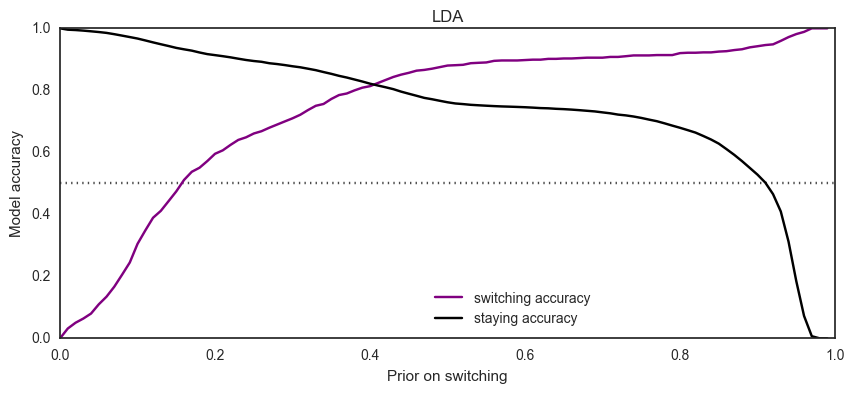

In [24]:
plt.figure(figsize=(10,4))
plt.plot(P,acc_cv[:,0],color='purple',label='switching accuracy')
plt.plot(P,acc_cv[:,1],color='black',label='staying accuracy')
plt.hlines(y=0.5,xmin=0,xmax=1,color='black',alpha=0.7,linestyle='dotted')
plt.legend(loc='lower right',bbox_to_anchor=[0.7,0])
plt.xlim(0,1)
plt.xlabel('Prior on switching')
plt.ylabel('Model accuracy')
plt.title('LDA')

In [25]:
lda = discriminant_analysis.LinearDiscriminantAnalysis(priors=[0.4,0.6])
lda.fit(x_train,y_train)
y_predict_lda = lda.predict(x_test)
acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict_lda,y_test,disp=True,confusion=False)

          Predicted NO  Predicted YES
True NO          770.0          275.0
True YES          12.0           76.0

F1: 0.346

Accuracy on class 0: 0.74
Accuracy on class 1: 0.86



//anaconda/envs/CaGRIN/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


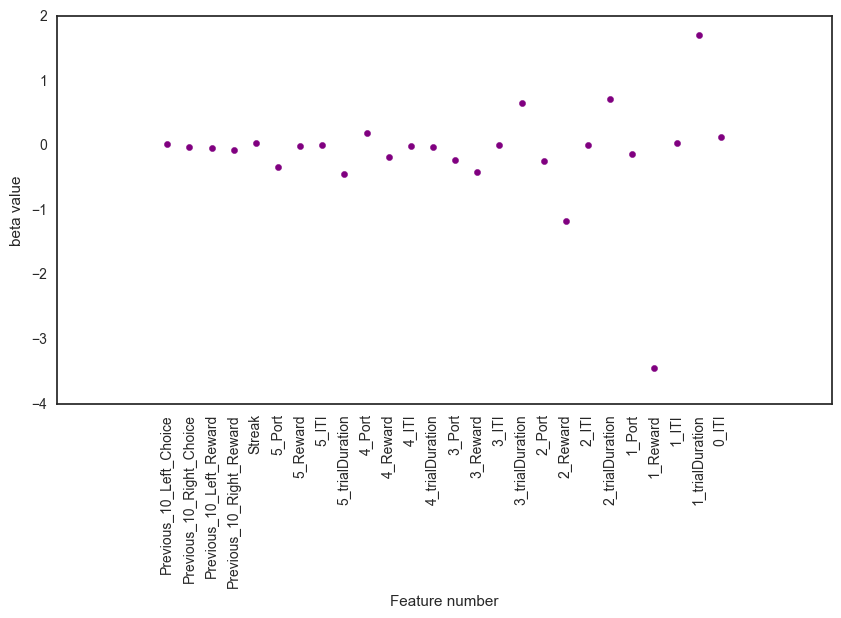

In [26]:
coefs = lda.coef_
plt.figure(figsize=(10,5))
plt.scatter(np.arange(coefs[0].shape[0]),coefs[0],color='purple')
plt.xticks(np.arange(coefs[0].shape[0]),feature_names,rotation='vertical')
plt.ylabel('beta value')
plt.xlabel('Feature number')

In [123]:
coefs.max()

1.0

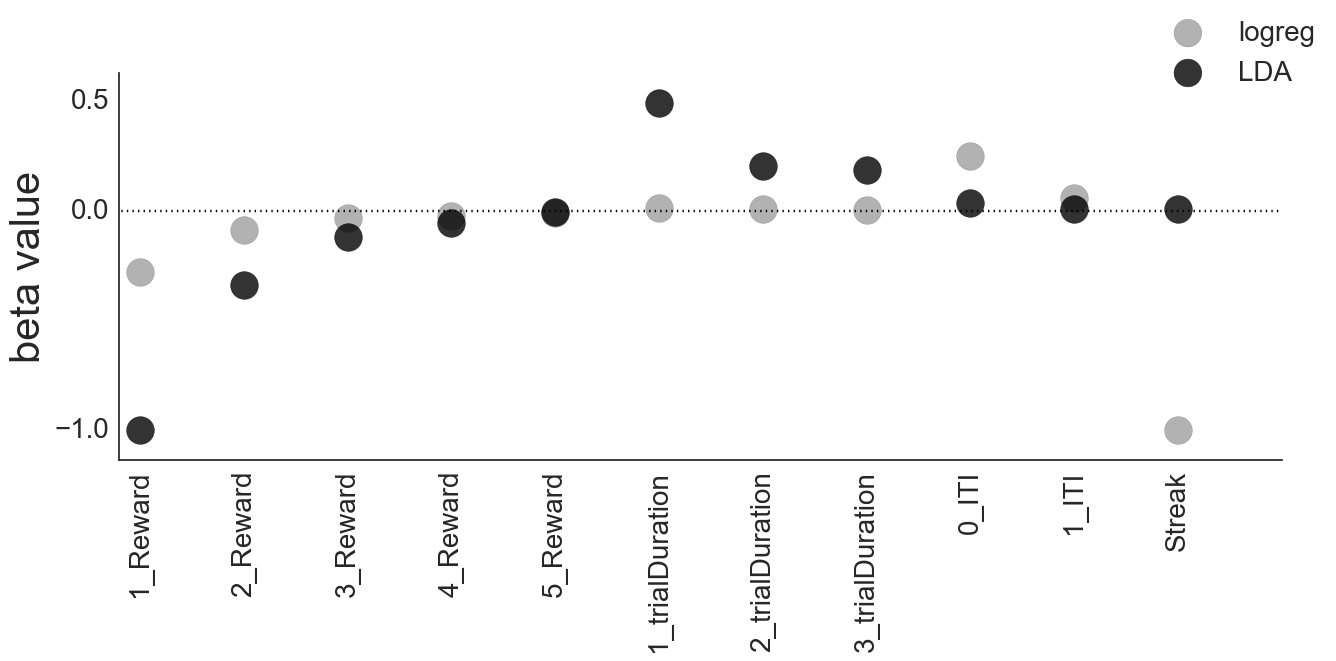

In [145]:
feature_order = ['1_Reward','2_Reward','3_Reward','4_Reward','5_Reward','1_trialDuration','2_trialDuration',
                '3_trialDuration','0_ITI','1_ITI','Streak']
order = []

for f in feature_order:
    order.append(data.columns.get_loc(f))

coefs = lda.coef_[0]
coefs = coefs / np.abs(coefs).max()
plt.figure(figsize=(15,5))
plt.scatter(np.arange(len(order)),coefs_lr[order],color='black',s=400,alpha=0.3,label='logreg')
plt.scatter(np.arange(len(order)),coefs[order],color='black',s=400,alpha=0.8,label='LDA')
plt.xticks(np.arange(len(order)),feature_names[order],rotation='vertical',fontsize=20)
plt.yticks([-1,0,0.5],fontsize=20)
plt.hlines(y=0,xmin=-0.5,xmax=27,linestyle='dotted')
plt.xlim(-0.2,11)
plt.ylabel('beta value',fontsize=30)
plt.legend(bbox_to_anchor=(1.05,1.2),fontsize=20)
sns.despine()

# Decision Tree

In [27]:
D = np.arange(1,17)

acc_cv = []

for i,d in enumerate(D):
    tree = Tree.DecisionTreeClassifier(max_depth=d,class_weight='balanced')

    kf = cross_validation.KFold(x_train.shape[0],n_folds=3)
    cum_acc_pos = 0
    cum_acc_neg = 0

    for train_index,test_index in kf:
        x_train_cv = x_train[train_index,:]
        y_train_cv = y_train[train_index]
        x_test_cv = x_train[test_index,:]
        y_test_cv = y_train[test_index]

        tree.fit(x_train_cv,y_train_cv)
        y_predict = tree.predict(x_test_cv)

        acc_pos,acc_neg,F1 = sf.score_both_and_confuse(y_predict,y_test_cv,confusion=False,disp=False)

        cum_acc_pos += acc_pos
        cum_acc_neg += acc_neg

    acc_cv.append([cum_acc_pos / 3.0,cum_acc_neg / 3.0])

acc_cv = np.asarray(acc_cv)

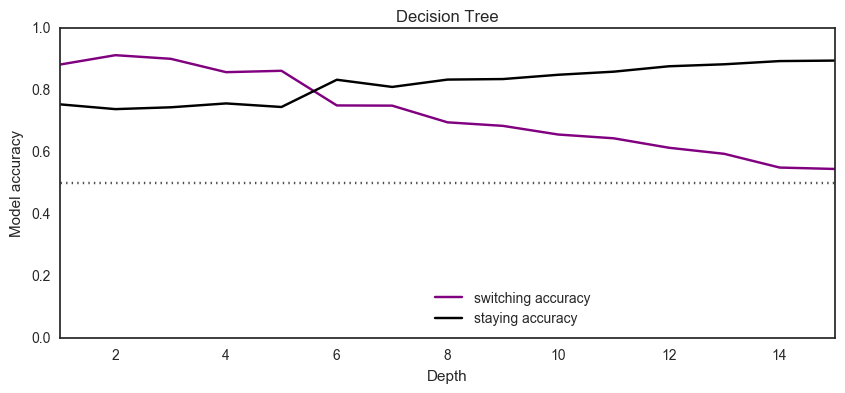

In [28]:
plt.figure(figsize=(10,4))
plt.plot(D,acc_cv[:,0],color='purple',label='switching accuracy')
plt.plot(D,acc_cv[:,1],color='black',label='staying accuracy')
plt.hlines(y=0.5,xmin=0,xmax=15,color='black',alpha=0.7,linestyle='dotted')
plt.legend(loc='lower right',bbox_to_anchor=[0.7,0])
plt.xlim(1,15)
plt.ylim(0,1)
plt.xlabel('Depth')
plt.ylabel('Model accuracy')
plt.title('Decision Tree')

In [112]:
tree = Tree.DecisionTreeClassifier(max_depth = 2,class_weight='balanced',random_state=20)
tree.fit(x_train,y_train)
y_predict_tree = tree.predict(x_test)
acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict_tree,y_test,disp=True,confusion=False)

          Predicted NO  Predicted YES
True NO          793.0          249.0
True YES           6.0           85.0

F1: 0.400

Accuracy on class 0: 0.76
Accuracy on class 1: 0.93



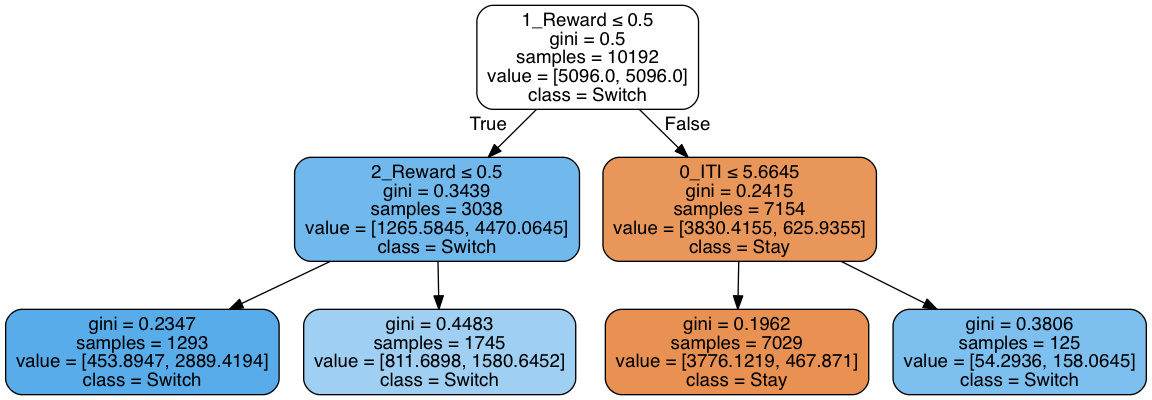

In [113]:
dot_data = Tree.export_graphviz(tree,out_file=None,
                     feature_names=data.columns.values[:-1],
                     class_names = ['Stay','Switch'],
                     filled=True,rounded=True,special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data)

Image(graph.create_png())

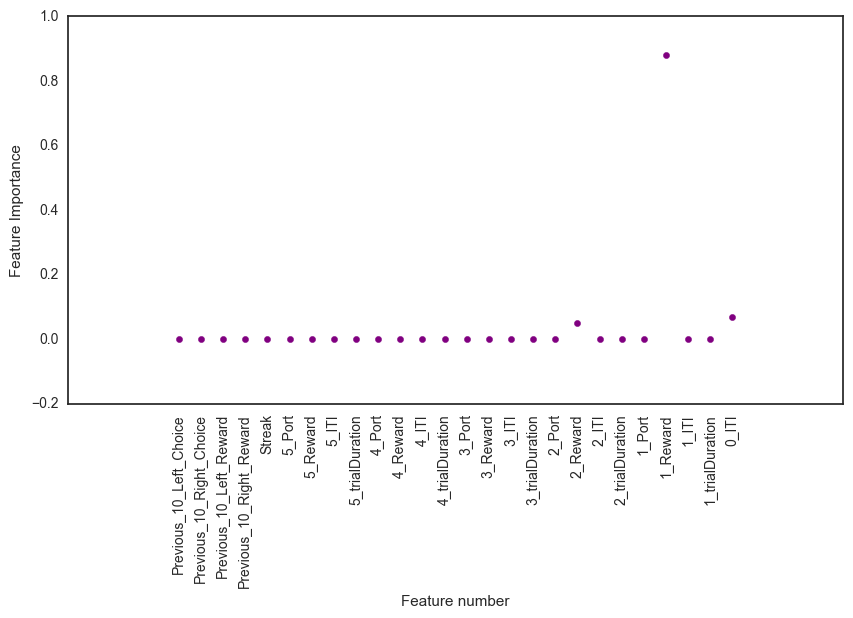

In [114]:
tree_f_impt = tree.feature_importances_
plt.figure(figsize=(10,5))
plt.scatter(np.arange(coefs[0].shape[0]),tree_f_impt,color='purple')
plt.xticks(np.arange(coefs[0].shape[0]),feature_names,rotation='vertical')
plt.ylabel('Feature Importance')
plt.xlabel('Feature number')

## ROC graph

In [3]:
from matplotlib import colors

In [4]:
greys = plt.cm.get_cmap('Greys')

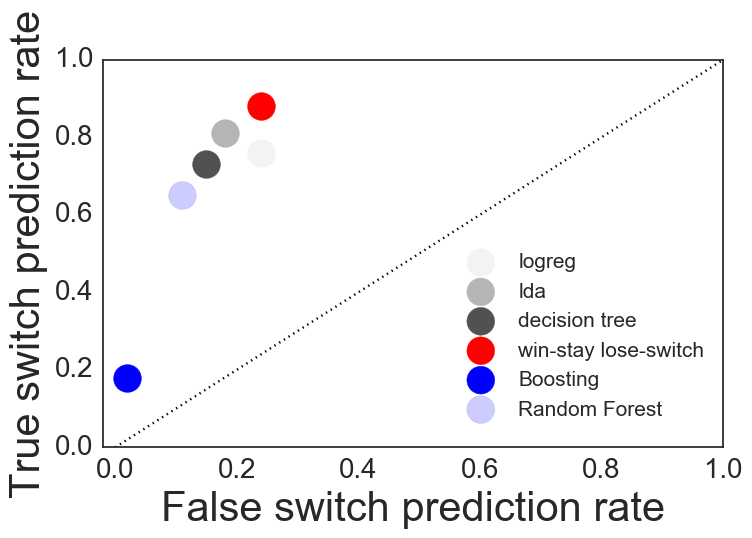

In [33]:
sns.set_style('white')
rocs = np.array([[.76,0.24],[0.81,0.18],[0.73,0.15],[0.88,0.24]])
#rocs_untuned = np.array([[0.01,0],[0,0],[0.16,0.02]])
plt.figure(figsize=(8,5))
plt.scatter(rocs[0,1],rocs[0,0],color=greys(0.1),label='logreg',s=400)
plt.scatter(rocs[1,1],rocs[1,0],color=greys(0.4),label='lda',s=400)
plt.scatter(rocs[2,1],rocs[2,0],color=greys(0.75),label='decision tree',s=400)
plt.scatter(rocs[3,1],rocs[3,0],color='red',label='win-stay lose-switch',s=400)
plt.scatter(0.02,0.18,color='blue',label='Boosting',s=400)
plt.scatter(0.11,0.65,color='blue',label='Random Forest',s=400,alpha=0.2)
plt.plot(np.linspace(0,1),np.linspace(0,1),color='black',linestyle='dotted')
plt.legend(bbox_to_anchor=(1.0,0.55),fontsize=15)
plt.xlim(-0.02,1)
plt.ylim(0,1)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('True switch prediction rate',fontsize=30)
plt.xlabel('False switch prediction rate',fontsize=30)

# Model accuracy graph

(array([    0.,   200.,   400.,   600.,   800.,  1000.]),
 <a list of 6 Text yticklabel objects>)

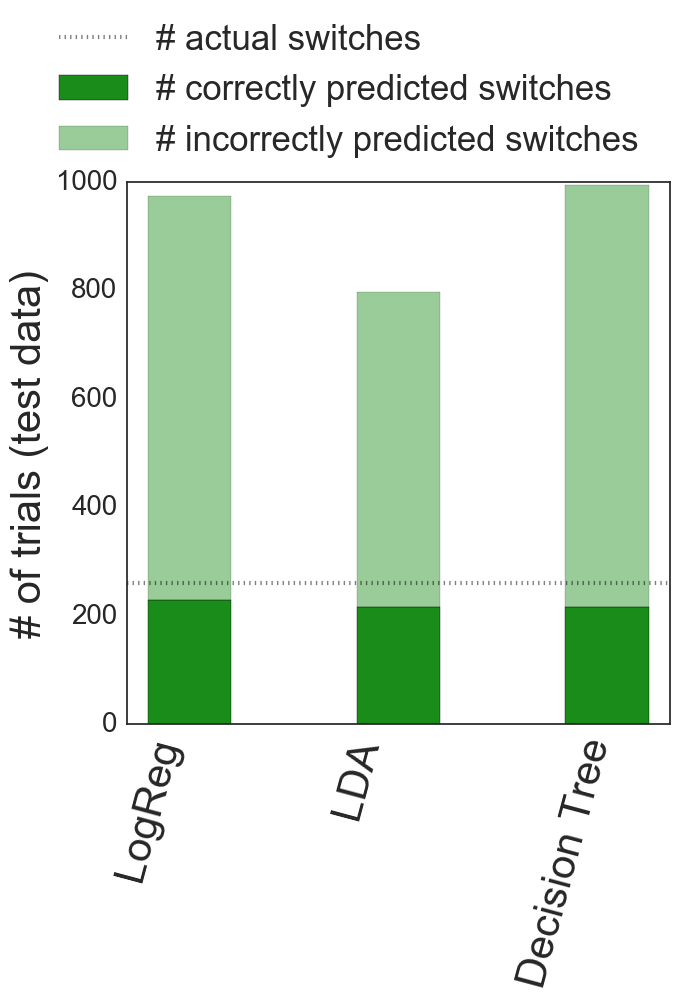

In [34]:
true_switches = np.array([229,216,216])
false_switches = np.array([746,581,778])
ind = np.arange(3)
plt.figure(figsize=(7,7))
plt.hlines(y=260,xmin=-0.1,xmax=3,linestyle='dotted',alpha=0.5,linewidth=3,label='# actual switches')
p1 = plt.bar(ind,true_switches,width=0.4,color='green',label='# correctly predicted switches',alpha=0.9)
p2 = plt.bar(ind,false_switches,width=0.4,color='green',bottom=true_switches,label='# incorrectly predicted switches',alpha=0.4)
plt.xlim(-0.1,2.5)
plt.legend(bbox_to_anchor=(1.0,1.35),fontsize=25)
plt.ylabel('# of trials (test data)',fontsize=30)
plt.xticks(ind,['LogReg','LDA','Decision Tree'],rotation=75,fontsize=30)
plt.yticks(fontsize=20)

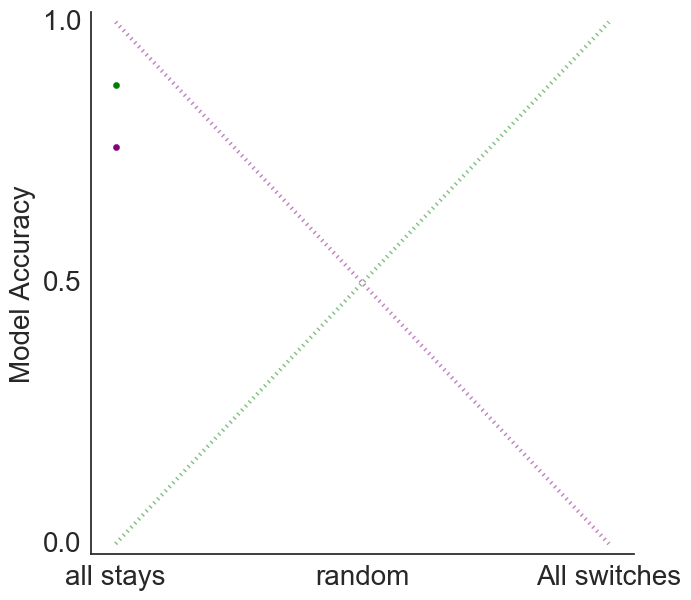

In [35]:
sns.set_style('white')
plt.figure(figsize=(7,7))
plt.plot([0,1,2],[0,0.5,1],color='green',alpha=0.5,linewidth=3,linestyle='dotted')
plt.plot([0,1,2],[1,0.5,0],color='purple',alpha=0.5,linewidth=3,linestyle='dotted')
#plt.scatter(x=[0,1,2],y=[0,0.5,1],label='switching accuracy',color='green',s=70)
#plt.scatter(x=[0,1,2],y=[1,0.5,0],label='staying accuracy',color='purple',s=70)
#plt.hlines(y=0.5,xmin=-0.5,xmax=2.5,linestyles='dotted',alpha=0.5)
plt.scatter(x=0,y=0.76,color='purple')
plt.scatter(x=0,y=0.88,color='green')
plt.xlim(-0.1,2.1)
plt.yticks([0,0.5,1],fontsize=20)
plt.ylabel('Model Accuracy',fontsize=20)
plt.xticks([0,1,2],['all stays','random','All switches'],fontsize=20)
plt.ylim(-0.02,1.02)

sns.despine()

(-0.1, 3.8)

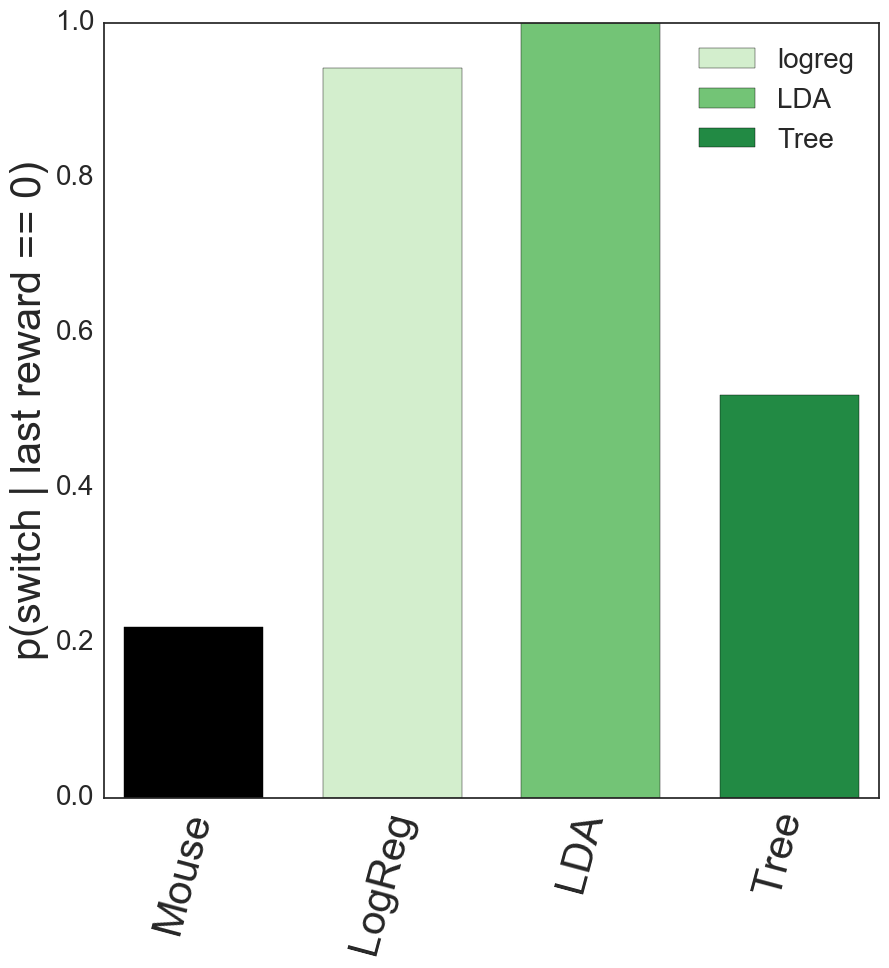

In [36]:
greens = plt.get_cmap('Greens')
plt.figure(figsize=(10,10))
plt.bar(left=1,height=y_predict_logreg[x_test[:,22]==0].mean(),width=0.7,color=greens(0.2),label='logreg')
plt.bar(left=2,height=y_predict_lda[x_test[:,22]==0].mean(),width=0.7,color=greens(0.5),label='LDA')
plt.bar(left=3,height=y_predict_tree[x_test[:,22]==0].mean(),width=0.7,color=greens(0.75),label='Tree')
plt.bar(left=0,height=y_test[x_test[:,22]==0].mean(),width=0.7,color='black')
plt.ylabel('p(switch | last reward == 0)',fontsize=30)
plt.legend(loc='upper right',fontsize=20)
plt.xticks([0.3,1.3,2.3,3.3],['Mouse','LogReg','LDA','Tree'],rotation=75,fontsize=30)
plt.yticks(fontsize=20)
plt.xlim(-0.1,3.8)


# Weights idea
assign weights propto negative streak value. IE the more you've gotten wrong in a row, the more likely you should be to switch. Actually - let's see if that's true first

In [37]:
streaks = np.unique(data['Streak'].values)
p_switch = np.zeros_like(streaks)

for i,s in enumerate(streaks):
    p_switch[i] = np.sum(data[data['Streak']== s]['Switch'].values).astype('float') / data[data['Streak']== s].shape[0]

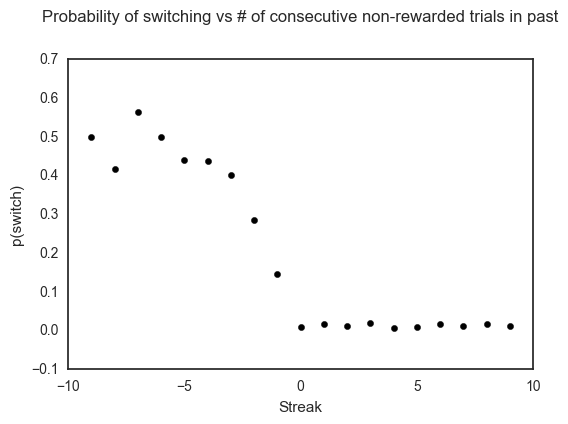

In [38]:
plt.scatter(streaks,p_switch,color='black')
plt.title('Probability of switching vs # of consecutive non-rewarded trials in past',x=0.5,y=1.1)
plt.ylabel('p(switch)')
plt.xlabel('Streak')

In [39]:
streaks = np.unique(data['Streak'].values)
p_switch_true = np.zeros_like(streaks)
p_switch_logreg = np.zeros_like(streaks)
p_switch_lda = np.zeros_like(streaks)
p_switch_tree = np.zeros_like(streaks)
p_switch_bench = np.zeros_like(streaks)

for i,s in enumerate(streaks):
    p_switch_true[i] = np.sum(data[data['Streak']== s]['Switch'].values).astype('float') / data[data['Streak']== s].shape[0]
    p_switch_logreg[i] = np.sum(y_predict_logreg[x_test[:,4] == s]).astype('float') / np.sum(x_test[:,4] == s)
    p_switch_lda[i] = np.sum(y_predict_lda[x_test[:,4] == s]).astype('float') / np.sum(x_test[:,4] == s)
    p_switch_tree[i] = np.sum(y_predict_tree[x_test[:,4] == s]).astype('float') / np.sum(x_test[:,4] == s)
    p_switch_bench[i] = np.sum(y_predict_bench[x_test[:,4] == s]).astype('float') / np.sum(x_test[:,4] == s)

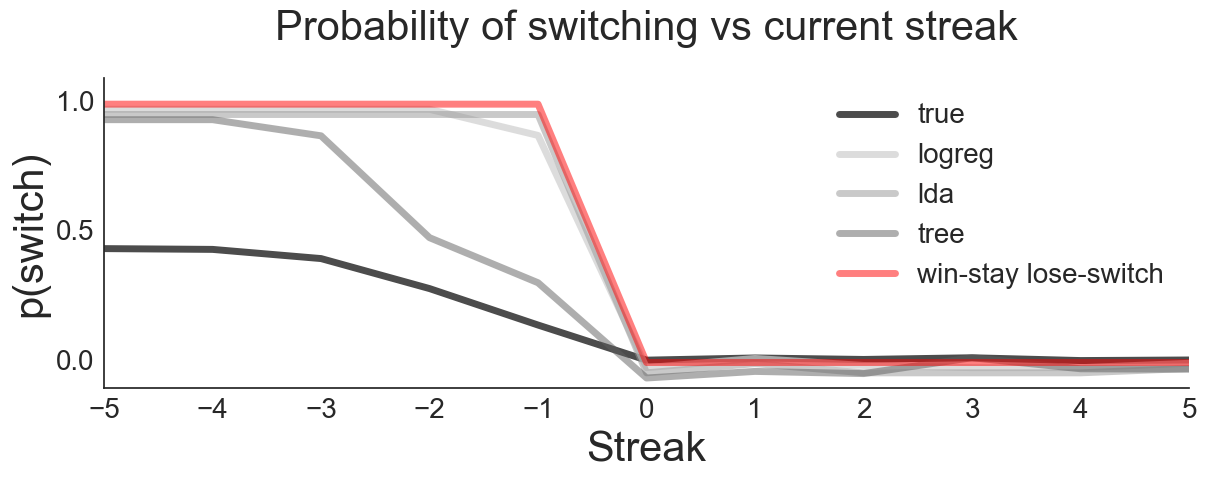

In [40]:
plt.figure(figsize=(14,4))
plt.plot(streaks,p_switch_true,color='black',label='true',alpha=0.7,linewidth=5)
plt.plot(streaks,p_switch_logreg-0.02,color=greys(0.3),label = 'logreg',alpha=0.7,linewidth=5)
plt.plot(streaks,p_switch_lda-0.04,color=greys(0.5),label='lda',alpha=0.5,linewidth=5)
plt.plot(streaks,p_switch_tree-0.06,color=greys(0.7),label='tree',alpha=0.5,linewidth=5)
plt.plot(streaks,p_switch_bench,color='red',label='win-stay lose-switch',alpha=0.5,linewidth=5)
plt.legend(bbox_to_anchor=(1.0,1),fontsize=20)
plt.title('Probability of switching vs current streak',x=0.5,y=1.1,fontsize=30)
plt.ylabel('p(switch)',fontsize=30)
plt.xlabel('Streak',fontsize=30)
plt.xticks(np.arange(-10,10,1),fontsize=20)
plt.yticks([0,0.5,1.0],fontsize=20)
plt.ylim(-0.1,1.1)
plt.xlim(-5,5)
sns.despine()

In [41]:
p_switch_true

array([ 0.5       ,  0.41666667,  0.56521739,  0.5       ,  0.44086022,
        0.43783784,  0.40229885,  0.28611898,  0.14499484,  0.00907912,
        0.01755292,  0.01181684,  0.01833977,  0.00752823,  0.00970874,
        0.01606426,  0.01265823,  0.01582278,  0.01209677])

In [42]:
data.shape[0]*.01

113.25

Should compare this graph with 90-10, 70-30 conditions.

This is where all of the false positives are coming!

# Try weighting training samples more if they have a negative streak value

In [43]:
data.columns.get_loc('2_Reward')

18

In [44]:
sample_weights = np.zeros_like(y_train)
sample_weights[x_train[:,18] == 1] += 0.01
sample_weights[x_train[:,14] == 1] += 0.5
sample_weights[x_train[:,10] == 1] += 0.3

### Decision Tree

In [45]:
weighted_tree = Tree.DecisionTreeClassifier(max_depth = 4,class_weight='balanced')
weighted_tree.fit(x_train,y_train,sample_weight=sample_weights)
y_predict = weighted_tree.predict(x_test)
acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict,y_test,disp=True,confusion=False)

          Predicted NO  Predicted YES
True NO          787.0          258.0
True YES          17.0           71.0

F1: 0.341

Accuracy on class 0: 0.75
Accuracy on class 1: 0.81



### Logistic Regression

In [46]:
weighted_logreg = sklearn.linear_model.LogisticRegressionCV(Cs=10,penalty='l2',class_weight='balanced')
weighted_logreg.fit(x_train,y_train,sample_weight=sample_weights)
y_predict = weighted_logreg.predict(x_test)
acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict,y_test,confusion=False)

          Predicted NO  Predicted YES
True NO          870.0          175.0
True YES          21.0           67.0

F1: 0.406

Accuracy on class 0: 0.83
Accuracy on class 1: 0.76



Well that doesn't seem to do much. 

## Models are having trouble predicting 'stay' when previous reward == 0. What do those trials look like?

In [47]:
data_noR_stay = data[data['1_Reward'] == 0]

In [48]:
p_switch_no2R = np.sum(data_noR_stay[data_noR_stay['2_Reward'] == 0]['Decision'].values).astype('float') / data_noR_stay[data_noR_stay['2_Reward'] == 0].shape[0]
p_switch_no3R = np.sum(data_noR_stay[data_noR_stay['3_Reward'] == 0]['Decision'].values).astype('float') / data_noR_stay[data_noR_stay['3_Reward'] == 0].shape[0]
p_switch_no4R = np.sum(data_noR_stay[data_noR_stay['4_Reward'] == 0]['Decision'].values).astype('float') / data_noR_stay[data_noR_stay['4_Reward'] == 0].shape[0]

p_switch_2R = np.sum(data_noR_stay[data_noR_stay['2_Reward'] == 1]['Decision'].values).astype('float') / data_noR_stay[data_noR_stay['2_Reward'] == 1].shape[0]
p_switch_3R = np.sum(data_noR_stay[data_noR_stay['3_Reward'] == 1]['Decision'].values).astype('float') / data_noR_stay[data_noR_stay['3_Reward'] == 1].shape[0]
p_switch_4R = np.sum(data_noR_stay[data_noR_stay['4_Reward'] == 1]['Decision'].values).astype('float') / data_noR_stay[data_noR_stay['4_Reward'] == 1].shape[0]

p_switch_noR = np.array([p_switch_no2R,p_switch_no3R,p_switch_no4R])
p_switch_R = np.array([p_switch_2R,p_switch_3R,p_switch_4R])

(0, 1)

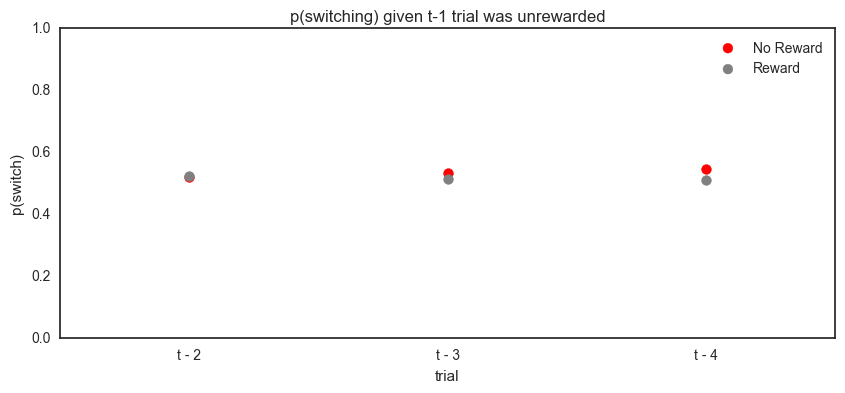

In [49]:
plt.figure(figsize=(10,4))
plt.scatter([2,3,4],p_switch_noR,color='red',label='No Reward',s=50)
plt.scatter([2,3,4],p_switch_R,color='grey',label = 'Reward',s=50)
plt.xticks([2,3,4],['t - 2','t - 3','t - 4'])
plt.xlabel('trial')
plt.ylabel('p(switch)')
plt.legend(loc='best')
plt.title('p(switching) given t-1 trial was unrewarded')
plt.ylim(0,1)

In [50]:
p_switch_R

array([ 0.52218782,  0.51479864,  0.50945136])

So here the t-2 no reward is a true streak of -2. But the rest aren't neccesarily - for t-3 to be unrewarded, the t-2 could have been rewarded. But remember this graph is *only for the case where t-1 was unrewarded*.

So what does this tell us. I'm struggling to take away a clear, coherent interpretation. My intuition is that we need to combine the 'reward streak' with some sort of 'port streak' metric. 

# Logistic Regression with interaction terms

In [51]:
poly = preprocessing.PolynomialFeatures(degree=2,interaction_only=True)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

In [52]:
poly_logreg = sklearn.linear_model.LogisticRegressionCV(Cs=10,penalty='l2',class_weight='balanced')
poly_logreg.fit(x_train_poly,y_train)
y_predict = poly_logreg.predict(x_test_poly)
acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict,y_test,confusion=False)

          Predicted NO  Predicted YES
True NO          811.0          234.0
True YES          26.0           62.0

F1: 0.323

Accuracy on class 0: 0.78
Accuracy on class 1: 0.70



But the interaction terms aren't really want we want: if we multiply 1_Reward = 0 with 2_Reward = 1 we just get 0. That's not very informative.

What if we instead calculate the fraction of rewarded trials in the last 5?

In [53]:
reward_outcomes = data[['1_Reward','2_Reward','3_Reward','4_Reward','5_Reward']].copy()
frac_reward = reward_outcomes.mean(axis=1)
frac_reward.shape

new_data = data.iloc[:,:-2].copy()
new_data['frac_reward'] = frac_reward
new_data['Decision'] = data['Decision'].values
new_data['Switch'] = data['Switch'].values
new_data.head(5)

,Previous_10_Left_Choice,Previous_10_Right_Choice,Previous_10_Left_Reward,Previous_10_Right_Reward,Streak,5_Port,5_Reward,5_ITI,5_trialDuration,4_Port,...,2_ITI,2_trialDuration,1_Port,1_Reward,1_ITI,1_trialDuration,0_ITI,frac_reward,Decision,Switch
1,10.0,0.0,7.0,0.0,-2.0,1.0,1.0,2.405,0.463,1.0,...,2.133,0.482,1.0,0.0,1.411,0.435,2.169,0.6,0.0,1.0
2,9.0,1.0,6.0,0.0,-3.0,1.0,1.0,2.379,0.367,1.0,...,1.411,0.435,0.0,0.0,2.169,0.395,3.838,0.4,0.0,0.0
3,8.0,2.0,5.0,0.0,-4.0,1.0,1.0,2.234,0.325,1.0,...,2.169,0.395,0.0,0.0,3.838,0.469,1.846,0.2,1.0,1.0
4,8.0,2.0,5.0,0.0,1.0,1.0,0.0,2.133,0.482,1.0,...,3.838,0.469,1.0,1.0,1.846,0.378,1.527,0.2,1.0,0.0
5,8.0,2.0,4.0,0.0,-1.0,1.0,0.0,1.411,0.435,0.0,...,1.846,0.378,1.0,0.0,1.527,0.416,1.635,0.2,1.0,0.0


## Take a look at mouse behavior vs frac_reward

In [54]:
reward_fractions = np.unique(new_data['frac_reward'].values)
p_switch_true = np.zeros_like(reward_fractions)

for i,s in enumerate(reward_fractions):
    p_switch_true[i] = np.sum(new_data[new_data['frac_reward']== s]['Switch'].values).astype('float') / new_data[new_data['frac_reward']== s].shape[0]

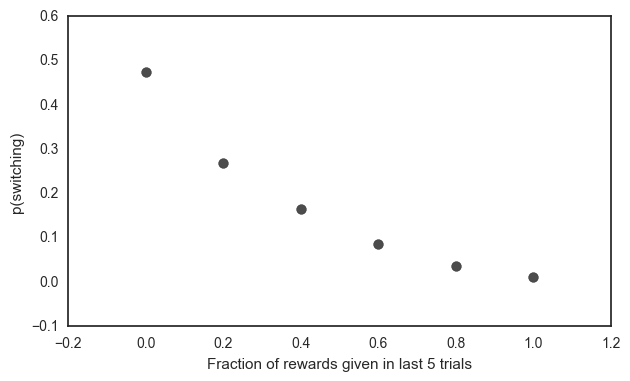

In [55]:
plt.figure(figsize=(7,4))
plt.scatter(reward_fractions,p_switch_true,color='black',label='true',s=50,alpha=0.7)
plt.ylabel('p(switching)')
plt.xlabel('Fraction of rewards given in last 5 trials')

*Note here fraction = 0.0 should be exactly equivalent to a streak of -5*

# Looking at p(switch) for each combination of last 3 reward outcomes

In [56]:
combinations = ['000','001','010','100','101','110','011','111']
data_3R = data[['1_Reward','2_Reward','3_Reward']]
row_str = []
for row in range(data_3R.shape[0]):
    row_str.append(np.array_str(data_3R.iloc[row,:].values.astype('int')))

In [57]:
combo = np.zeros((len(row_str),len(set(row_str))))
for j,s in enumerate(set(row_str)): 
    for i,row in enumerate(row_str):
        combo[i,j] = s == row

In [58]:
num_combo = np.zeros(len(set(row_str)))
num_switch = np.zeros(len(set(row_str)))
p_switch_combo = np.zeros(len(set(row_str)))

for c in range(combo.shape[1]):
    num_combo[c] = np.sum(combo[:,c])
    num_switch[c] = np.sum(data.iloc[np.where(combo[:,c] == 1)]['Switch'].values)
    p_switch_combo[c] = num_switch[c]/num_combo[c].astype('float')

In [59]:
combinations = []
for s in set(row_str):
    combinations.append(s)
combinations = np.asarray(combinations)

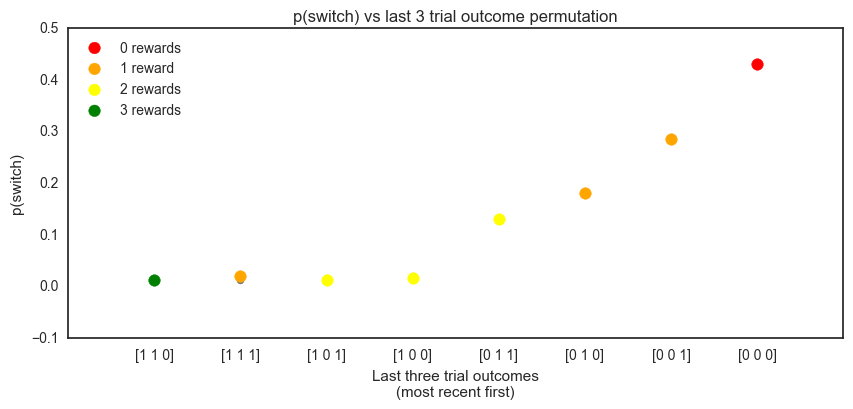

In [60]:
plt.figure(figsize=(10,4))
plt.scatter(np.arange(p_switch_combo.shape[0]),np.sort(p_switch_combo),color='black',s=25,alpha=0.5)

#0 rewards
plt.scatter([7],np.sort(p_switch_combo)[7],color='red',s=70,label='0 rewards')
#1 reward
plt.scatter([1,5,6],np.sort(p_switch_combo)[[3,5,6]],color='orange',s=70,label='1 reward')
#2 rewards
plt.scatter([2,3,4],np.sort(p_switch_combo)[[0,2,4]],color='yellow',s=70,label='2 rewards')
#3 rewards
plt.scatter([0],np.sort(p_switch_combo)[1],color='green',s=70,label='3 rewards')

plt.legend(loc='upper left')
plt.xticks(np.arange(p_switch_combo.shape[0]),combinations[np.argsort(p_switch_combo)])
plt.title('p(switch) vs last 3 trial outcome permutation')
plt.ylabel('p(switch)')
plt.xlabel('Last three trial outcomes\n(most recent first)')

In [61]:
#extract features and decisions
x = new_data.iloc[:,:-2].values
y = new_data.iloc[:,-1].values

#split into training and testing
n_trials = x.shape[0]
shuf_inds = np.random.permutation(n_trials)
split_ind = int(n_trials*0.7)

x_train = x[shuf_inds[:split_ind],:]
y_train = y[shuf_inds[:split_ind]]

x_test_ = x[shuf_inds[split_ind:],:]
y_test_ = y[shuf_inds[split_ind:]]

In [62]:
logreg = sklearn.linear_model.LogisticRegressionCV(Cs=10,penalty='l2',class_weight='balanced')
logreg.fit(x_train_,y_train)
y_predict = logreg.predict(x_test_)
acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict,y_test_,confusion=False)

NameError: name 'x_train_' is not defined

In [ ]:
coefs = logreg.coef_
plt.figure(figsize=(10,5))
plt.scatter(np.arange(coefs[0].shape[0]),coefs[0],color='purple')
plt.xticks(np.arange(coefs[0].shape[0]),new_data.columns.values[:-2],rotation='vertical')
plt.ylabel('beta value')
plt.xlabel('Feature number')

In [ ]:
lda = discriminant_analysis.LinearDiscriminantAnalysis(priors=[0.6,0.4])
lda.fit(x_train,y_train)
y_predict = lda.predict(x_test)
acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict,y_test,disp=True,confusion=False)

In [ ]:
coefs = lda.coef_
plt.figure(figsize=(10,5))
plt.scatter(np.arange(coefs[0].shape[0]),coefs[0],color='purple')
plt.xticks(np.arange(coefs[0].shape[0]),new_data.columns.values[:-2],rotation='vertical')
plt.ylabel('beta value')
plt.xlabel('Feature number')

# Single feature decision trees

In [ ]:
features = new_data.columns.values[:-2]
P = np.arange(0.8,1.0,0.01)
F1 = np.zeros(x.shape[1])
w = np.zeros(x.shape[1])

for i in range(x.shape[1]):
    
    for p in P:
        prior = np.array([1.0-p,p])
        tree = Tree.DecisionTreeClassifier(max_depth=1,class_weight={0:prior[0],1:prior[1]})

        kf = model_selection.KFold(n_splits=3)
        cum_F1 = 0.0

        for train_index,test_index in kf.split(x_train):
            x_train_cv = x_train[train_index,i].reshape(x_train[train_index].shape[0],1)
            y_train_cv = y_train[train_index]
            x_test_cv = x_train[test_index,i].reshape(x_train[test_index].shape[0],1)
            y_test_cv = y_train[test_index]

            tree.fit(x_train_cv,y_train_cv)
            y_predict = tree.predict(x_test_cv)

            acc_pos,acc_neg,F1_k = sf.score_both_and_confuse(y_predict,y_test_cv,confusion=False,disp=False)

            cum_F1 += F1_k

        F1_cv = cum_F1 / 3.0

        if F1_cv > F1[i]:
            F1[i] = F1_cv
            w[i] = p

In [ ]:
plt.figure(figsize=(10,3))
fig,ax1 = plt.subplots()
ax1.scatter(np.arange(x.shape[1]),F1,color='black')
plt.xticks(np.arange(x.shape[1]),new_data.columns.values[:-2],rotation = 90)
ax1.set_ylim(0,0.4)
#ax1.set_yticklabels(['','',0.10,0.15,0.20,0.25,0.30])
ax1.set_ylabel('F1 score')
ax1.yaxis.set_label_coords(-0.1,.65)

ax2 = ax1.twinx()
ax2.scatter(np.arange(x.shape[1]),w,color='red')
ax2.set_ylim(0.8,1.5)
ax2.set_yticks([0.7,0.8,0.9,1.0])
ax2.set_ylabel('Class Weight',color='r',)
ax2.yaxis.set_label_coords(1.1,0.15)
ax2.grid('off')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
plt.title('Single feature trees tuned for class weights')

# Gaussian Mixture Model

In [ ]:
from sklearn import mixture

In [ ]:
gmm = mixture.GaussianMixture(n_components=2,n_init=5)
gmm.fit(x_train,y_train)

In [ ]:
y_predict = gmm.predict(x_test)

In [ ]:
acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict,y_test,disp=True,confusion=False)

this is the exact same as LDA

In [ ]:
plt.scatter(np.arange(27),gmm.means_[0],color='purple')
plt.scatter(np.arange(27),gmm.means_[1],color='green')

In [ ]:
qda = discriminant_analysis.QuadraticDiscriminantAnalysis(priors=[0.05,0.95])
qda.fit(x_train,y_train)
y_predict_qda = qda.predict(x_test)
acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict_qda,y_test,disp=True,confusion=False)

In [ ]:
coefs = lda.coef_
plt.figure(figsize=(10,5))
plt.scatter(np.arange(coefs[0].shape[0]),coefs[0],color='purple')
plt.xticks(np.arange(coefs[0].shape[0]),feature_names,rotation='vertical')
plt.ylabel('beta value')
plt.xlabel('Feature number')

In [ ]:
data.iloc[0,:]